In [16]:
import geopandas as gpd
import numpy as np
import pandas as pd
import atlite
import cartopy.io.shapereader as shpreader
from regiondefinitions import regions_dic
import h5py
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors

def get_countries(region: str, dictionary: dict = regions_dic):
      for _, value in dictionary.items():
            if value["region"] == region:
                  return value['countries']
      raise ValueError("Region not in dictionary.")

def res_capacity_atlite(filepath: str, gisregion: str, carrier: str, year: int, per_unit_bool: bool):
      cutout = atlite.Cutout(path=filepath)
      countries = list(gisregion)
      gisregion = 'GermanyAustria'
      all_regions = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
      region = all_regions[all_regions['name'].isin(countries)]
      region_bounds = region.total_bounds
      region_cutout = cutout.sel(bounds=region_bounds)
      print(f"Calculating {carrier} capacity factors for {gisregion}...")
      if carrier == "wind":
            path_to_nc = f'/Volumes/fi246disk/Atlite/wind_cap_f/wind-cap-factors-{gisregion}-{year}-jan-dec-hourly.nc'
            wind = region_cutout.wind( 
                  turbine="Vestas_V112_3MW", 
                  shapes=region['geometry'],
                  per_unit=per_unit_bool
            )
            #wind.to_netcdf(path_to_nc)
            print(f'Wind capacity factors for {gisregion} saved to: {path_to_nc}')
            return wind
      
      elif carrier == "pv":
            path_to_nc = f'/Volumes/fi246disk/test/pv-cap-factors-{gisregion}-{year}-jan-dec-hourly.nc'
            pv = region_cutout.pv(
                  panel='CSi',
                  orientation="latitude_optimal",
                  shapes=region['geometry'],
                  per_unit=per_unit_bool
            )
            #pv.to_netcdf(path_to_nc)
            print(f'PV capacity factors for {gisregion} saved to: {path_to_nc}')
            return pv
      
      else:
            raise ValueError("Invalid carrier. Available: \"wind\"; \"pv\".")

def vre_gen_potential_atlite(gisregion: str, carrier: str, year: int, density: int = 1.0, land_available: int = 1.0):
    #print(f"Calculating {carrier} for {gisregion}")
    filepath = f"/Volumes/fi246disk/Atlite/{carrier}_cap_f/{carrier}-cap-factors-{gisregion}-{year}-jan-dec-hourly.nc"
    ds = xr.open_dataset(filepath)
    time_index = pd.date_range(start="2050-01-01 00:00:00", end="2050-12-31 23:00:00", freq="h")
    countries = get_countries(gisregion)
    all_regions = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    region = all_regions[all_regions['name'].isin(countries)]
    region = region.to_crs(epsg=3395) # Re-project the geometries to a suitable projected CRS 
    values = ds['__xarray_dataarray_variable__'].values
    areas = region.geometry.area.values # m2
    if values.shape[1] != areas.shape[0]:
        raise ValueError(f"Shape mismatch: values shape {values.shape[1]} and areas shape {areas.shape[0]}")
    series_sum = (values * areas).sum(axis=1)
    series = pd.Series(series_sum, index=time_index)
    return series * density * land_available * 1E-06 # MW



In [17]:
cutout_path = '/Volumes/fi246disk/cutouts/global-2023-jan-dec-era5-hourly.nc'
series_germany_per_unit_true = res_capacity_atlite(cutout_path, ['Germany', 'Austria'], 'pv', 2023, per_unit_bool=True)

/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_31556/283377040.py:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  all_regions = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Calculating pv capacity factors for GermanyAustria...
[########################################] | 100% Completed | 171.00 s
PV capacity factors for GermanyAustria saved to: /Volumes/fi246disk/test/pv-cap-factors-GermanyAustria-2023-jan-dec-hourly.nc


<xarray.DataArray (time: 8760, dim_0: 2)> Size: 140kB
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
  * dim_0    (dim_0) int64 16B 114 121
Attributes:
    units:    p.u.

In [18]:
series_germany_per_unit_false = res_capacity_atlite(cutout_path, ['Germany', 'Austria'], 'pv', 2023, per_unit_bool=False)

/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_31556/283377040.py:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  all_regions = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Calculating pv capacity factors for GermanyAustria...
[########################################] | 100% Completed | 186.46 s
PV capacity factors for GermanyAustria saved to: /Volumes/fi246disk/test/pv-cap-factors-GermanyAustria-2023-jan-dec-hourly.nc


In [19]:
series_germany_per_unit_false

<xarray.DataArray 'specific generation' (time: 8760, dim_0: 2)> Size: 140kB
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
  * dim_0    (dim_0) int64 16B 114 121
Attributes:
    units:    MW

In [21]:
print(series_germany_per_unit_true['dim_0'].values)

[114 121]


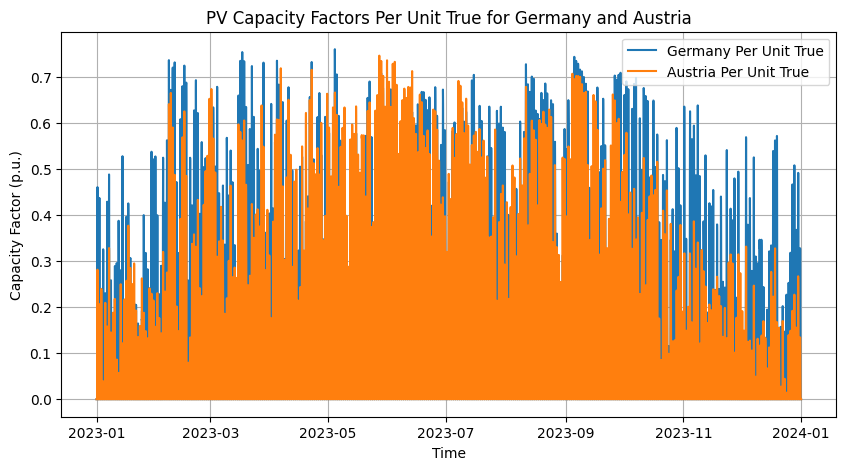

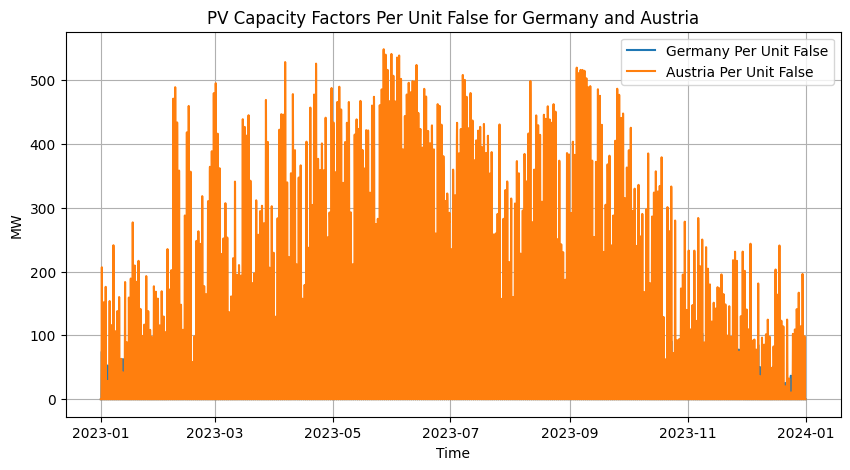

In [24]:
import matplotlib.pyplot as plt

# Plotting the first series
plt.figure(figsize=(10, 5))
plt.plot(series_germany_per_unit_true.time, series_germany_per_unit_true.sel(dim_0=114), label='Germany Per Unit True')
plt.plot(series_germany_per_unit_true.time, series_germany_per_unit_true.sel(dim_0=121), label='Austria Per Unit True')
plt.xlabel('Time')
plt.ylabel('Capacity Factor (p.u.)')
plt.title('PV Capacity Factors Per Unit True for Germany and Austria')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the second series
plt.figure(figsize=(10, 5))
plt.plot(series_germany_per_unit_false.time, series_germany_per_unit_false.sel(dim_0=114), label='Germany Per Unit False')
plt.plot(series_germany_per_unit_false.time, series_germany_per_unit_false.sel(dim_0=121), label='Austria Per Unit False')
plt.xlabel('Time')
plt.ylabel('MW')
plt.title('PV Capacity Factors Per Unit False for Germany and Austria')
plt.legend()
plt.grid(True)
plt.show()
